In [21]:
import numpy as np
import os
import mne
import pandas as pd
import hmp  
import matplotlib.pyplot as plt
import time
import math

In [22]:
# -------------------------------
# Function to epoch the data
# -------------------------------
def epoch_data_all_subjects(files, session_str):
    epoch_dict = {}

    for file in files: 
        if session_str in file.split('_')[1][2:4]:
            print(f"Processing file: {file}")
            
            # 1. Read data
            raw = mne.io.read_raw_fif(os.path.join(epoch_data_path, file), preload=True)

           # 2. Extract annotations
            annotations = raw.annotations
            onset = annotations.onset
            description = annotations.description

            # 3. Create dataframe
            df = pd.DataFrame({"description": description, "onset": onset})

            # 4. Filter events
            df_filtered = df[df["description"].isin(["stim-all_stim", "trial_end"])].reset_index(drop=True)

            # 5. Map to event IDs
            mapping = {"stim-all_stim": 1, "trial_end": 2}
            df_filtered["event_id"] = df_filtered["description"].map(mapping)

            # 6. Convert to samples
            sfreq = int(raw.info['sfreq'])
            df_filtered["sample"] = (df_filtered["onset"] * sfreq).astype(int)

            # 7. Create previous column
            df_filtered["previous"] = 0

            # 8. Arrange columns
            df_events = df_filtered[["sample", "previous", "event_id"]]

            # 9. Convert to numpy
            events = df_events.values

            # 10. Define IDs
            event_id = {"stimulus": 1}
            resp_id = {"response": 2}

            # 11. Epoch data
            epoch_data = hmp.utils.read_mne_data(
                os.path.join(epoch_data_path, file),
                event_id=event_id,
                resp_id=resp_id,
                sfreq=100,
                events_provided=events,
                verbose=False,
                tmin=-0.2,
                tmax=15)

            # 12. Store in dictionary
            subject_id = "subject_" + file.split('_')[1][0:2]
            print(f"✅ Storing data for {subject_id}")
            epoch_dict[subject_id] = epoch_data

    return epoch_dict

In [23]:
# -------------------------------
# Function to read the behavioral file per subject
# -------------------------------
def read_beh_data(files, session_str, beh_path):
    beh_dict = {}
    for file in files: 
        file_subject = file.split('-')[0]
        file_session = file.split('-')[1]
        if file_session == session_str:
            df = pd.read_csv(os.path.join(beh_path, file))
            subject_id = "subject_" + file_subject
            beh_dict[subject_id] = df
            print(f"✅ Behavioral data loaded for subject {subject_id}")
    return beh_dict

In [24]:
# -------------------------------
# Load epoch data and path
# -------------------------------
epoch_data_path = os.path.join(os.getcwd())
files = [x for x in os.listdir(epoch_data_path) if "preprocessed-raw.fif" in x]

In [25]:
# -------------------------------
# Epoch the data for the third session
# -------------------------------
epoch_data_third_session = epoch_data_all_subjects(files, "03")

Processing file: subj_0203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif...
    Range : 0 ... 2918399 =      0.000 ...  1425.000 secs
Ready.
Reading 0 ... 2918399  =      0.000 ...  1425.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif's continuous eeg
Downsampling to 100 Hz
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif
✅ Storing data for subject_02
Processing file: subj_0403_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif...
    Range : 0 ... 2779135 =      0.000 ...  1357.000 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  1357.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif's continuous eeg
Downsampling to 100 Hz
80 trials were re

In [26]:
# -------------------------------
# Read behavioral files for session 3
# -------------------------------
beh_path = os.path.join(os.getcwd())
beh_files = [x for x in os.listdir(beh_path) if '.csv' in x]
beh_data_third_session = read_beh_data(beh_files, "03", beh_path)

✅ Behavioral data loaded for subject subject_02
✅ Behavioral data loaded for subject subject_04
✅ Behavioral data loaded for subject subject_05
✅ Behavioral data loaded for subject subject_06
✅ Behavioral data loaded for subject subject_08
✅ Behavioral data loaded for subject subject_09
✅ Behavioral data loaded for subject subject_10
✅ Behavioral data loaded for subject subject_11
✅ Behavioral data loaded for subject subject_12
✅ Behavioral data loaded for subject subject_14
✅ Behavioral data loaded for subject subject_15
✅ Behavioral data loaded for subject subject_16
✅ Behavioral data loaded for subject subject_17
✅ Behavioral data loaded for subject subject_19
✅ Behavioral data loaded for subject subject_20
✅ Behavioral data loaded for subject subject_22
✅ Behavioral data loaded for subject subject_25


# Safety Check: Coparison of RT distributions

I compare the RT distribution derived from the behevioral file to the RT disrtibution derived from the data to ensure that the data has been epoched correctly

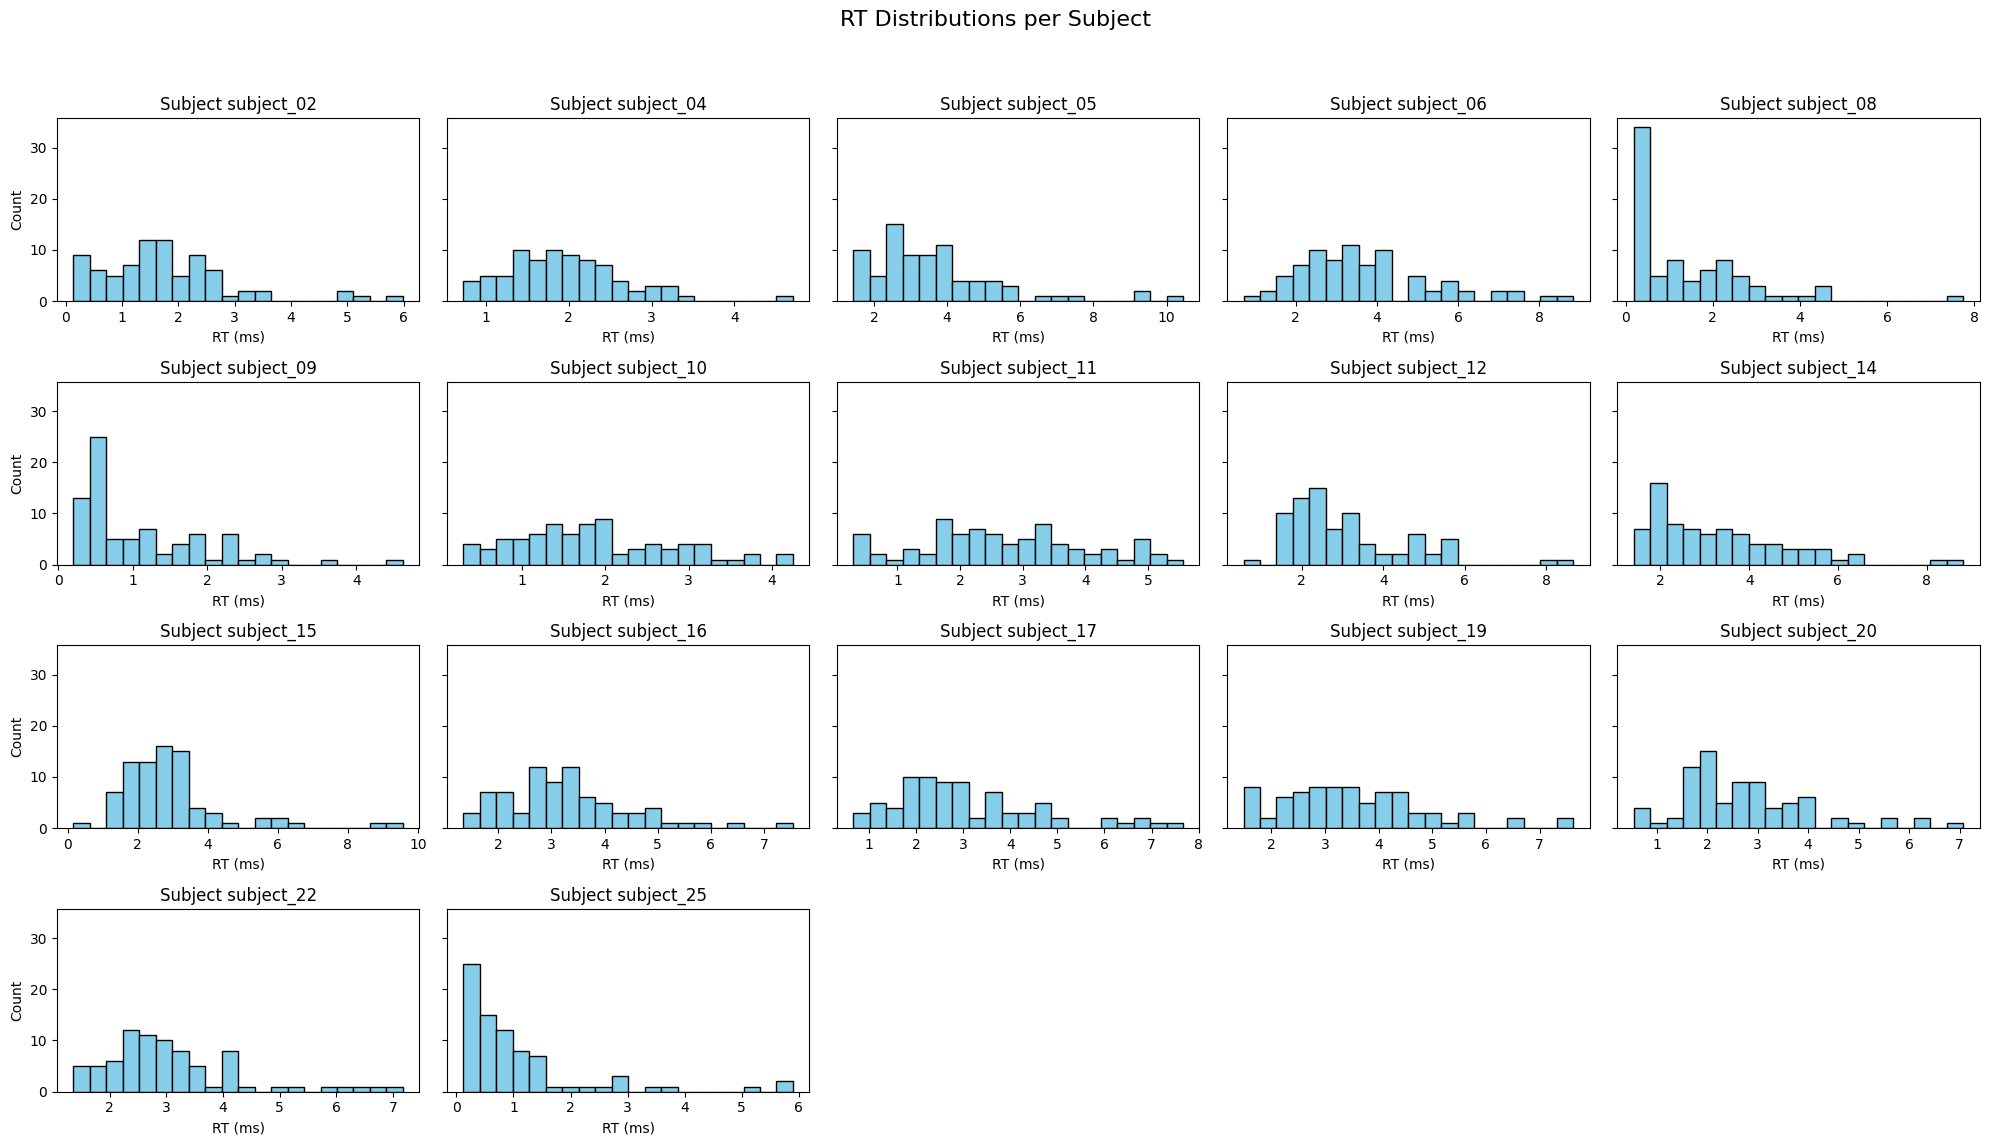

In [27]:
# -------------------------------
# RT distribution derived from data
# -------------------------------
subjects = list(epoch_data_third_session.keys())
n_subjects = len(subjects)

# Choose a grid layout
n_cols = 5
n_rows = math.ceil(n_subjects / n_cols)

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharey=True)
axes = axes.flatten()  

# Plot RT histograms
for i, subject in enumerate(subjects):
    epoch_data = epoch_data_third_session[subject]
    axes[i].hist(epoch_data.rt, bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Subject {subject}')
    axes[i].set_xlabel('RT (ms)')
    if i % n_cols == 0:
        axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("RT Distributions per Subject", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


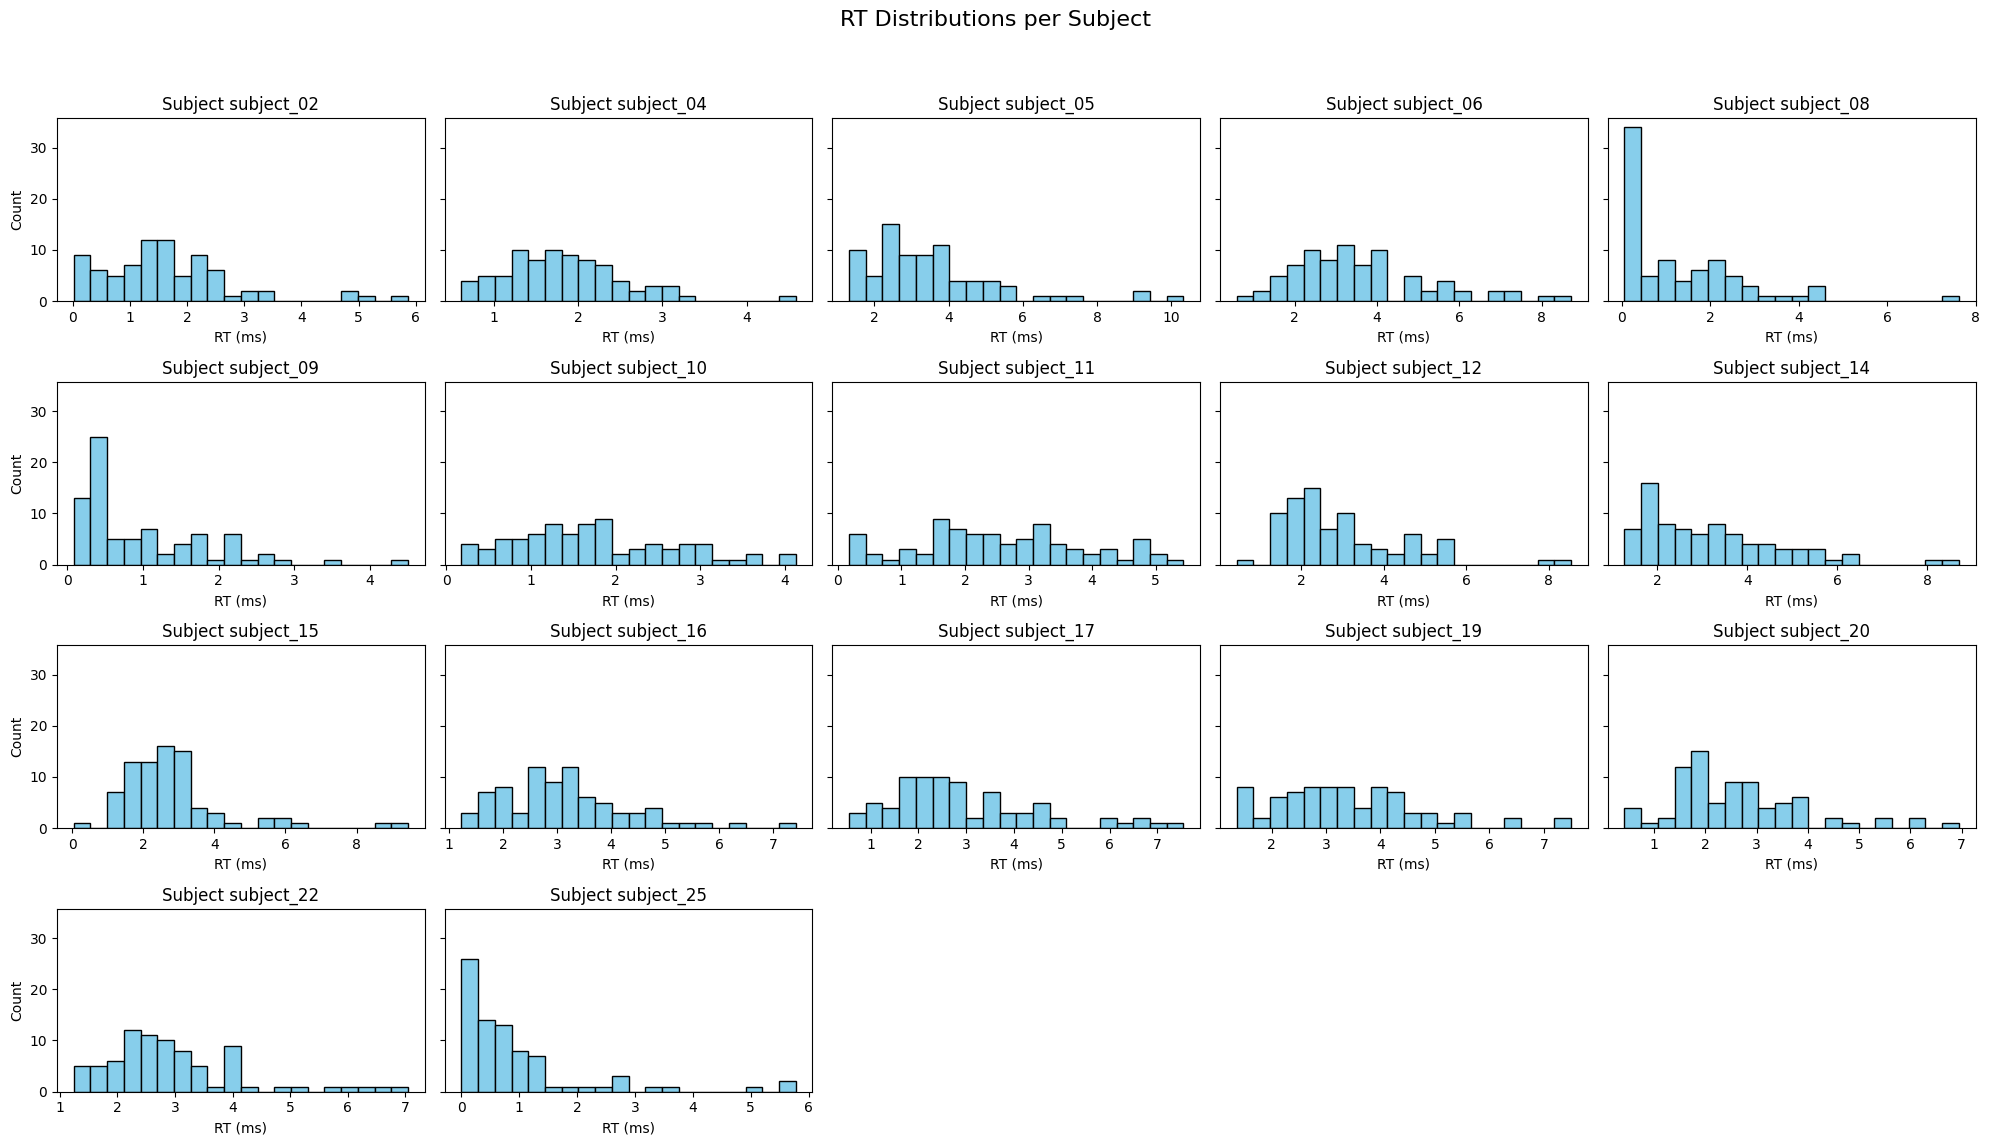

In [57]:
# -------------------------------
# RT distribution derived from behavioral file 
# -------------------------------
subjects = list(beh_data_third_session.keys())
n_subjects = len(subjects)

n_cols = 5
n_rows = math.ceil(n_subjects / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharey=True)
axes = axes.flatten()  

for i, subject in enumerate(subjects):
    beh_data = beh_data_third_session[subject]
    axes[i].hist(beh_data.rt, bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Subject {subject}')
    axes[i].set_xlabel('RT (ms)')
    if i % n_cols == 0:
        axes[i].set_ylabel('Count')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("RT Distributions per Subject", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()